In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import pickle as pkl
from copy import deepcopy
from typing import *
import mediapipe as mp

import torch

from utils import *

In [3]:
import pandas as pd

from dataloader import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from tqdm import tqdm
import os
import multiprocessing
import pickle as pkl
from typing import *

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

import plotly
import plotly.express as px
import plotly.io as plt_io
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
connections = mp.solutions.holistic.HAND_CONNECTIONS

In [38]:
connections

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})

In [27]:
landmarks = all_data['Chir1'][1].reshape((21,3))

In [29]:
landmarks.shape

(21, 3)

In [30]:
landmarks

array([[ 1.17956050e-01,  3.86922002e-01,  2.85356577e-07],
       [ 1.53046966e-01,  3.79127532e-01, -8.06213543e-03],
       [ 1.93493754e-01,  3.85696083e-01, -2.12342963e-02],
       [ 2.15485349e-01,  4.00940537e-01, -3.05188764e-02],
       [ 2.25425065e-01,  4.14891720e-01, -3.87997963e-02],
       [ 1.81898087e-01,  3.83483320e-01, -5.49634807e-02],
       [ 2.28869364e-01,  4.06931847e-01, -7.01234043e-02],
       [ 2.48677626e-01,  4.21701908e-01, -7.25638717e-02],
       [ 2.58760899e-01,  4.32769269e-01, -7.10212067e-02],
       [ 1.54501513e-01,  3.94099057e-01, -5.53346686e-02],
       [ 2.03108758e-01,  4.24469411e-01, -6.97074756e-02],
       [ 2.22733438e-01,  4.33521330e-01, -6.39272109e-02],
       [ 2.29718730e-01,  4.36683774e-01, -5.71877360e-02],
       [ 1.34487882e-01,  4.05817300e-01, -5.28542772e-02],
       [ 1.83035329e-01,  4.35721636e-01, -6.02923892e-02],
       [ 2.03951105e-01,  4.37725633e-01, -4.72301729e-02],
       [ 2.09200978e-01,  4.33369815e-01

In [31]:
tmp = list(map(lambda t: landmarks[t[1]] - landmarks[t[0]], connections))

In [35]:
tmp[0]

array([ 0.00993972,  0.01395118, -0.00828092])

In [37]:
landmarks[0] - landmarks[1]

array([-0.03509092,  0.00779447,  0.00806242])

In [3]:
path_data_dir = "../data/hands_landmarks"

In [ ]:
'''

part1 = load_pickle(os.path.join(path_data_dir, "Intern_08_data.pkl"))
part2 = load_pickle(os.path.join(path_data_dir, "Intern_08_2_data.pkl"))
fusion = deepcopy(part1)

part1_max_frame_id = max(list(part1.keys()))
part2_max_frame_id = max(list(part2.keys()))
cpt = part1_max_frame_id

for frame_id in tqdm(part2.keys()):
    cpt += 1
    fusion[cpt] = part2[frame_id]

assert max(list(fusion.keys())) == part1_max_frame_id + part2_max_frame_id

save_pickle(os.path.join(path_data_dir, "Intern_008_data.pkl"), fusion)
'''

### Data loading

In [5]:
def data_loading(path_data_dir:str, filenames:str) -> dict:
    all_data = {}
    for file in tqdm(filenames):
        if file[0] == 'I':
            subject_id = file[:9]
        else:
            subject_id = file[:5]
        all_data[subject_id] = {}
        data = load_pickle(os.path.join(path_data_dir, file))
        for frame_id in data.keys():
            try:
                all_data[subject_id][frame_id] = data[frame_id]['Left']
            except:
                pass   
    print("data loading completed ...")
    return all_data

In [6]:
path_data_dir = "../data/hands_landmarks"
filenames = sorted([file for file in os.listdir("../data/hands_landmarks") if file[0] == 'I' or file[0] == 'C'])

In [7]:
# data loading
all_data = data_loading(path_data_dir, filenames)

100%|██████████| 28/28 [00:00<00:00, 28.83it/s]

data loading completed ...


## Data processing

In [4]:
def data_loading(path_data_dir:str, filenames:str, every:int=1) -> dict:
    all_data = {}
    for file in tqdm(filenames):
        if file[0] == 'I':
            subject_id = file[:9]
        else:
            subject_id = file[:5]
        all_data[subject_id] = {}
        data = load_pickle(os.path.join(path_data_dir, file))
        for idx, frame_id in enumerate(list(data.keys())):
            if idx % every == 0:
                try:
                    all_data[subject_id][frame_id] = data[frame_id]['Left']
                except:
                    pass
    print("data loading completed ...")
    return all_data

def sliding_window(data:np.array, window_size:int, overlap:float) -> np.array:
    overlap = int(window_size * (overlap / 100))
    out = np.array([data[i:i+window_size] for i in range(0, len(data), window_size-overlap) if len(data[i:i+window_size]) == window_size])
    return out


def make_window(data:dict, window_size:int, overlap:float):
    L = []
    for key in data.keys():
        L.append(data[key])
    tmp = np.array(L)
    out = sliding_window(tmp, window_size, overlap)
    return out

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def create_dataset(data:dict, subjects:List[str], window_size:int=60, overlap:float=0.0): 
    labels = [] 
    for idx, subject_id in tqdm(enumerate(subjects), total=len(subjects)):     
        if subject_id[0] == 'I':
            label = 0
        else:
            label = 1
        if idx == 0:
            win_data = make_window(data[subject_id], window_size, overlap)
            all_data_part1 = win_data
            labels.extend([label] * win_data.shape[0])
        else:
            win_data = make_window(data[subject_id], window_size, overlap)
            all_data_part2 = win_data
            labels.extend([label] * win_data.shape[0])

        if idx == 0:
            all_data = all_data_part1
        else:
            all_data = np.vstack((all_data, all_data_part2))
            
    X, Y = unison_shuffled_copies(np.array(all_data), np.array(labels))
    X = torch.Tensor(X)
    Y = torch.Tensor(Y).long()

    return X, Y


def plot_pca(X:pd.DataFrame):

    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    #X_normalized = scaler.transform(X)

    pca = PCA(n_components=3)

    X_pca = pca.fit_transform(X_normalized)

    print("Explained variance ratio 3 composants:" , pca.explained_variance_ratio_)
    print("Singular values 3 composants: ", pca.singular_values_)

    new_df = pd.DataFrame(X_pca, columns=['pca_1','pca_2','pca_3'])
    new_df['labels'] = y

    fig = px.scatter_3d(new_df, x='pca_1', y='pca_2', z='pca_3', color='labels', size_max=10)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()


def plot_tsne(X:pd.DataFrame):
    
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    X_tsne = TSNE(n_components=3, learning_rate='auto',
                  init='random').fit_transform(X_normalized)
    
    new_df = pd.DataFrame(X_tsne, columns=['tsne_1','tsne_2','tsne_3'])
    new_df['labels'] = y

    fig = px.scatter_3d(new_df, x='tsne_1', y='tsne_2', z='tsne_3', color='labels')
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

def plot_2d(component1, component2, y):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=10,
            color=y, #set color equal to a variable
            #colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=700,height=500)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

def plot_3d(component1, component2, component3, y):
    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=5,
                color=y,                # set color to an array/list of desired values
                #colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=1000,height=700)
    #fig.layout.template = 'plotly_dark'
    fig.write_image("test.png") 
    
    fig.show()

In [8]:
# data loading
all_data = data_loading(path_data_dir, filenames)

100%|██████████| 28/28 [00:00<00:00, 29.48it/s]

data loading completed ...


In [ ]:
all_data['Chir1'].keys()

In [60]:
t1 = all_data['Chir1'][1].reshape((21,3))
t2 = all_data['Chir1'][2].reshape((21,3))

In [70]:
t3 = np.linalg.norm(t2 - t1, axis=1)
t3.shape

(21,)

In [71]:
t3

array([0.01655065, 0.01389458, 0.01307672, 0.01109101, 0.01115388,
       0.01150091, 0.01444473, 0.01196875, 0.00901855, 0.01024183,
       0.01231005, 0.00910783, 0.00532321, 0.00894876, 0.00992449,
       0.0077242 , 0.00463454, 0.0074107 , 0.00802796, 0.00783776,
       0.0065089 ])

In [41]:
from itertools import combinations

In [42]:
all_dist = []
for l1, l2 in combinations(t,2):
    dist=np.linalg.norm(l1-l2)
    all_dist.append(dist)

In [44]:
len(all_dist)

210

In [47]:
np.array([np.linalg.norm(p[0]-p[1]) for p in combinations(t,2)]).shape

(210,)

In [ ]:
[p for p in L]

In [8]:
class FeatureExtraction:
    def __init__(self, extraction:str=None):
        self.extraction = extraction

    def run(self, data):
        if self.extraction == 'raw':
            return self._raw_landmarks(data)
        elif self.extraction == 'dist':
            return self._distance_landmarks(data)
        else:
            pass

    def _raw_landmarks(self, data:np.array):
        return data

    def _distance_landmarks(self, data:np.array):
        #print(data.shape)
        #'''
        out = []
        for (l1, l2) in combinations(data, 2):
            dist = np.linalg.norm(l1-l2)
            out.append(dist)
        return np.array(out)
        #'''

    def _angles_landmarks(self):
        pass

    def _consecutive_distance(self):
        pass


# dist, cons_dist, angles


class DataLoading:

    def __init__(self, directory:str, filenames:List[str], extraction:str, every:int=1):
        self.directory = directory
        self.filenames = filenames
        self.every = every
        self.feature_extraction = FeatureExtraction(extraction)


    def run(self):
        all_data = {}
        for file in tqdm(self.filenames):
            if file[0] == 'I':
                subject_id = file[:9]
            else:
                subject_id = file[:5]   
            all_data[subject_id] = {}
            data = load_pickle(os.path.join(self.directory, file))
            for idx, frame_id in tqdm(enumerate(list(data.keys()))):
                if idx % self.every == 0:
                    try:
                        all_data[subject_id][frame_id] = self.feature_extraction.run(data[frame_id]['Left'])
                    except:
                        pass
        print("data loading completed ...")
        return all_data

In [9]:
path_data_dir = "../data/hands_landmarks"
filenames = sorted([file for file in os.listdir("../data/hands_landmarks") if file[0] == 'I' or file[0] == 'C'])

In [10]:
dl = DataLoading(path_data_dir, filenames, 'dist', 1)
all_data = dl.run()

15216it [01:31, 165.57it/s]0<?, ?it/s]
9709it [00:47, 203.49it/s]31<41:22, 91.93s/it]
15116it [01:34, 160.62it/s]9<28:34, 65.93s/it]
6919it [00:42, 162.21it/s]53<32:50, 78.81s/it]
14033it [01:07, 207.59it/s]6<25:48, 64.54s/it]
10536it [00:59, 177.09it/s]4<25:09, 65.65s/it]
13571it [01:09, 194.64it/s]3<23:18, 63.56s/it]
26235it [02:30, 174.78it/s]3<22:57, 65.58s/it]
14713it [01:23, 176.42it/s]3<30:50, 92.50s/it]
15031it [01:03, 238.57it/s]6<28:23, 89.66s/it]
 36%|███▌      | 10/28 [12:49<24:25, 81.44s/it]
1176it [00:07, 174.19it/s]

In [199]:
out1 = all_data['Chir1'][1]

In [10]:
def reshape_temporal_landmarks(data, ws, overlap=0):
    all_df = pd.DataFrame()
    start_id = 0
    cpt = 0
    y = []

    for subject_id in tqdm(all_data.keys()):
        label = 0 if subject_id.startswith('C') else 1
        data_win = make_window(all_data[subject_id], ws, overlap)
        for win_idx in range(data_win.shape[0]):
            df = pd.DataFrame(data_win[win_idx,:,:], columns=['feat_' + str(idx) for idx in range(63)])
            df['time'] = [i for i in range(1,len(df)+1)]
            df['id'] = [(start_id + win_idx) for _ in range(len(df))]
            all_df = pd.concat([all_df, df])
            y.append(label)
        start_id += (win_idx+1)
    
    return all_df, y

In [11]:
len(all_data['Chir1'])

15140

In [12]:
all_df, y = reshape_temporal_landmarks(all_data, ws=100)

100%|██████████| 28/28 [00:59<00:00,  2.12s/it]


In [13]:
all_df.reset_index(drop=True, inplace=True)
y = np.array(y)

In [18]:
all_df.shape, y.shape

((346300, 65), (3463,))

In [15]:
all_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,time,id
0,0.117956,0.386922,2.853566e-07,0.153047,0.379128,-0.008062,0.193494,0.385696,-0.021234,0.215485,...,0.438754,-0.051042,0.186654,0.438980,-0.039412,0.193505,0.434531,-0.028805,1,0
1,0.101412,0.386470,3.435135e-07,0.139825,0.378564,-0.003829,0.182483,0.385090,-0.014206,0.208812,...,0.439926,-0.043460,0.183299,0.439522,-0.032350,0.190033,0.434250,-0.023307,2,0
2,0.093177,0.388346,3.150043e-07,0.130802,0.381340,-0.003627,0.174718,0.386656,-0.012880,0.203953,...,0.443390,-0.040903,0.179401,0.442844,-0.030374,0.185152,0.437684,-0.020871,3,0
3,0.093914,0.389550,2.925435e-07,0.133714,0.384082,-0.003104,0.177005,0.391834,-0.011821,0.204865,...,0.447864,-0.039652,0.173955,0.447469,-0.028377,0.179512,0.442588,-0.018689,4,0
4,0.095978,0.393567,2.688094e-07,0.136671,0.387915,-0.004087,0.179313,0.395896,-0.012594,0.204663,...,0.451454,-0.037330,0.176432,0.451662,-0.026292,0.183658,0.447311,-0.016078,5,0


In [19]:
all_df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,time,id
0,0.117956,0.386922,2.853566e-07,0.153047,0.379128,-0.008062,0.193494,0.385696,-0.021234,0.215485,...,0.438754,-0.051042,0.186654,0.438980,-0.039412,0.193505,0.434531,-0.028805,1,0
1,0.101412,0.386470,3.435135e-07,0.139825,0.378564,-0.003829,0.182483,0.385090,-0.014206,0.208812,...,0.439926,-0.043460,0.183299,0.439522,-0.032350,0.190033,0.434250,-0.023307,2,0
2,0.093177,0.388346,3.150043e-07,0.130802,0.381340,-0.003627,0.174718,0.386656,-0.012880,0.203953,...,0.443390,-0.040903,0.179401,0.442844,-0.030374,0.185152,0.437684,-0.020871,3,0
3,0.093914,0.389550,2.925435e-07,0.133714,0.384082,-0.003104,0.177005,0.391834,-0.011821,0.204865,...,0.447864,-0.039652,0.173955,0.447469,-0.028377,0.179512,0.442588,-0.018689,4,0
4,0.095978,0.393567,2.688094e-07,0.136671,0.387915,-0.004087,0.179313,0.395896,-0.012594,0.204663,...,0.451454,-0.037330,0.176432,0.451662,-0.026292,0.183658,0.447311,-0.016078,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346295,0.233839,0.513848,-9.722498e-08,0.275158,0.502327,0.007790,0.317959,0.506536,0.012863,0.343052,...,0.563890,-0.005739,0.325536,0.558758,0.003228,0.318171,0.553625,0.010196,96,3575
346296,0.234197,0.513990,-9.725095e-08,0.274799,0.502437,0.008103,0.317575,0.506107,0.013309,0.342860,...,0.564021,-0.005754,0.326883,0.559177,0.003527,0.320593,0.553961,0.010859,97,3575
346297,0.233718,0.513952,-9.344888e-08,0.274775,0.502218,0.007704,0.317788,0.506188,0.012552,0.343203,...,0.563900,-0.005466,0.326492,0.558926,0.003697,0.319886,0.553843,0.010976,98,3575
346298,0.234875,0.513540,-9.750433e-08,0.275554,0.502235,0.007847,0.318028,0.505789,0.012907,0.343222,...,0.564307,-0.006104,0.327353,0.559782,0.003310,0.321330,0.554713,0.010895,99,3575


In [16]:
extraction_settings = ComprehensiveFCParameters()

# MinimalFCParameters, EfficientFCParameters

X = extract_features(all_df, column_id='id', column_sort='time',
                    default_fc_parameters=MinimalFCParameters(),
                    impute_function=impute, n_jobs=10)

X_filtered = select_features(X, y, n_jobs=10)

Feature Extraction: 100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


In [17]:
X_filtered.shape, X.shape

((3463, 337), (3463, 630))

In [137]:
X_filtered.columns

Index(['feat_2__mean', 'feat_2__sum_values', 'feat_2__median',
       'feat_2__maximum', 'feat_2__minimum', 'feat_37__maximum',
       'feat_37__absolute_maximum', 'feat_61__absolute_maximum',
       'feat_61__maximum', 'feat_49__maximum',
       ...
       'feat_58__root_mean_square', 'feat_47__maximum', 'feat_58__median',
       'feat_40__standard_deviation', 'feat_40__variance',
       'feat_41__sum_values', 'feat_41__mean', 'feat_43__standard_deviation',
       'feat_43__variance', 'feat_41__median'],
      dtype='object', length=129)

In [158]:
X_ = X_filtered

scaler = StandardScaler()
scaler.fit(X_)
X_normalized = scaler.transform(X_)

pca = PCA(n_components=min(X_.shape[0], X_.shape[1]))
pca.fit(X_normalized)

X_pca = pca.fit_transform(X_normalized)

plot_3d(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], y)

In [101]:
save_pickle('X_raw_1000.pkl', X)

In [105]:
save_pickle('X_filt_1000.pkl', X_filtered)

In [31]:
X = load_pickle('X_raw_1000.pkl')

In [32]:
X.shape, y.shape

((357, 49329), (357,))

In [33]:
X_filtered = select_features(X, y, n_jobs=10)

In [46]:
X_filtered.shape

(357, 38)

In [47]:
y_copy = deepcopy(y)

In [48]:
np.random.shuffle(y_copy)

In [51]:
X_filtered = select_features(X, y_copy, n_jobs=10)

In [53]:
X_filtered.shape

(357, 0)

In [58]:
out = []
for i in tqdm(range(10)):
    y_copy = deepcopy(y)
    np.random.shuffle(y_copy)
    X_filtered = select_features(X, y_copy, n_jobs=10)
    out.append(X_filtered)

100%|██████████| 10/10 [03:02<00:00, 18.25s/it]


In [68]:
out[9]

""
0
1
2
3
4
...
352
353
354
355


In [96]:
def reshape_temporal_landmarks(data, ws, overlap=0):
    all_df = pd.DataFrame()
    start_id = 0
    cpt = 0
    y = []

    for subject_id in tqdm(all_data.keys()):
        label = np.random.randint(0,2)
        data_win = make_window(all_data[subject_id], ws, overlap)
        for win_idx in range(data_win.shape[0]):
            df = pd.DataFrame(data_win[win_idx,:,:], columns=['feat_' + str(idx) for idx in range(63)])
            df['time'] = [i for i in range(1,len(df)+1)]
            df['id'] = [(start_id + win_idx) for _ in range(len(df))]
            all_df = pd.concat([all_df, df])
            y.append(label)
        start_id += (win_idx+1)
    all_df.reset_index(drop=True, inplace=True)
    return all_df, np.array(y)


In [121]:
out = []
for i in tqdm(range(10)):
    all_df, y = reshape_temporal_landmarks(all_data, ws=1000)
    y_copy = deepcopy(y)
    #np.random.shuffle(y_copy)
    X_filtered = select_features(X, y_copy, n_jobs=10)
    out.append((X_filtered, y_copy))

100%|██████████| 10/10 [04:01<00:00, 24.15s/it]


In [98]:
len(out)

10

In [142]:
for i in range(len(out)):
    print(out[i][0].shape)

(357, 21)
(357, 912)
(357, 372)
(357, 4963)
(357, 2770)
(357, 4516)
(357, 540)
(357, 0)
(357, 97)
(357, 1244)


In [136]:
out[2][0].shape, out[2][1].shape

((357, 372), (357,))

In [148]:
X_ = out[9][0]
y_ = out[9][1]

scaler = StandardScaler()
scaler.fit(X_)
X_normalized = scaler.transform(X_)

pca = PCA(n_components=min(X_.shape[0], X_.shape[1]))
pca.fit(X_normalized)

X_pca = pca.fit_transform(X_normalized)

plot_3d(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], y_)

In [91]:
from copy import deepcopy

In [149]:
#X = deepcopy(X_filtered)

X_ = X_filtered

scaler = StandardScaler()
scaler.fit(X_)
X_normalized = scaler.transform(X_)

pca = PCA(n_components=min(X_.shape[0], X_.shape[1]))
pca.fit(X_normalized)

X_pca = pca.fit_transform(X_normalized)

In [150]:
pca.explained_variance_ratio_[:10]

array([9.92476842e-01, 7.52315755e-03, 3.12528799e-33])

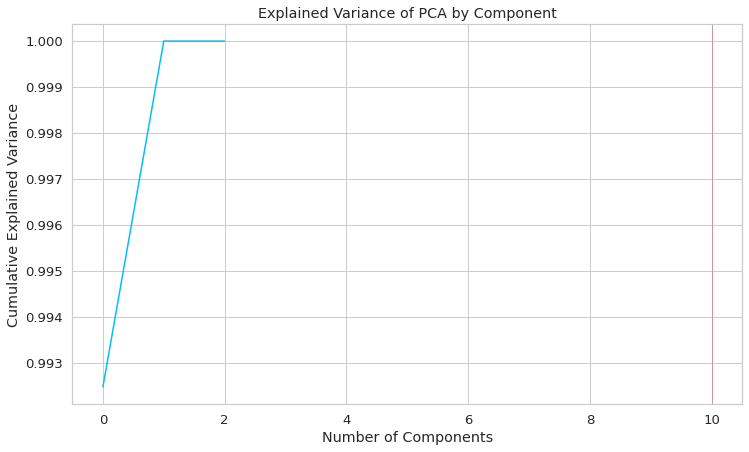

In [151]:
ax = plt.figure(figsize=[12,7]).gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=10, linewidth=1, color='r', alpha=0.5)
plt.title('Explained Variance of PCA by Component')
plt.show()

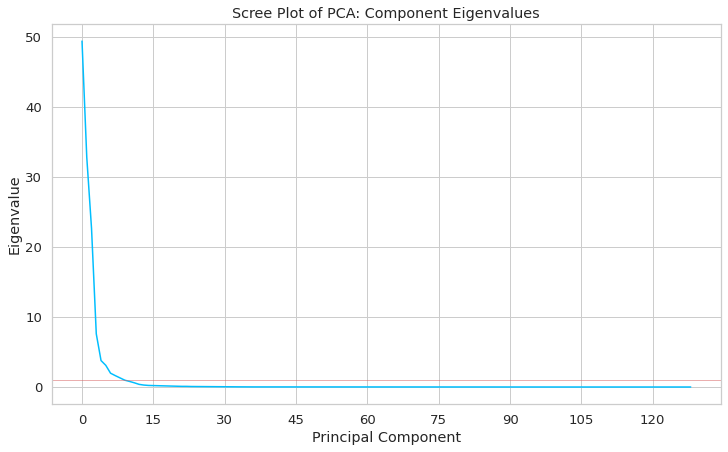

In [141]:
ax = plt.figure(figsize=[12,7]).gca()
ax.plot(pca.explained_variance_)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')
plt.show()

In [152]:
plot_2d(X_pca[:, 0], X_pca[:, 1], y)

In [157]:
plot_3d(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], y)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly
import plotly.express as px
from tqdm import tqdm
import os
from copy import deepcopy
import multiprocessing
from typing import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

from dataloader.build_dataset import *
from utils import *

In [128]:
every = 1
window_size = 350
overlap = 0

# data loading
path_data_dir = "../data/hands_landmarks"
filenames = sorted([file for file in os.listdir("../data/hands_landmarks") if file[0] == 'I' or file[0] == 'C'])

all_data = data_loading(path_data_dir, filenames, every)

100%|██████████| 28/28 [00:00<00:00, 33.95it/s]

data loading completed ...


In [129]:
hand = all_data['Chir1'][1000].reshape((21,3))

In [130]:
df = pd.DataFrame(hand, columns=['X', 'Y', 'Z'])

In [131]:
fig = px.scatter(df, x='X', y='Y')
fig.show()

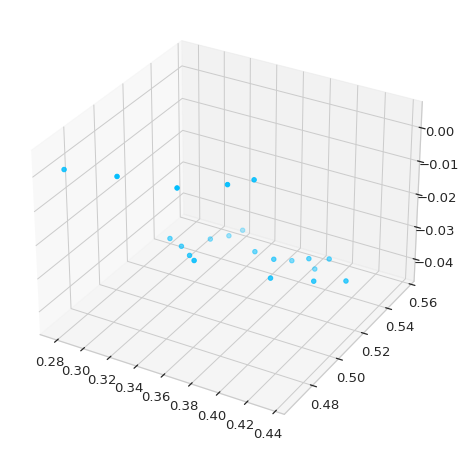

In [133]:
ax = plt.axes(projection='3d')

ax.scatter3D(hand[:,0], hand[:,1], hand[:,2])

### Sliding window

In [205]:
def sliding_window(all_data, ws, overlap):
    
    all_df = pd.DataFrame()
    y = []
    start_id = 0
    cpt = 0

    for idx, subject_id in enumerate(all_data.keys()):

        label = 0 if subject_id.startswith('C') else 1
        #label = idx
        data_win = make_window(all_data[subject_id], ws, overlap)
        
        for win_idx in range(data_win.shape[0]):

            df = pd.DataFrame(data_win[win_idx,:,:], columns=['feat_' + str(idx) for idx in range(63)])
            df['time'] = [i for i in range(1,len(df)+1)]
            df['id'] = [(start_id + win_idx) for _ in range(len(df))]
            all_df = pd.concat([all_df, df])
            y.append(label)

        start_id += (win_idx+1)

    all_df.reset_index(drop=True, inplace=True)
    y = np.array(y)

    return all_df, y

In [206]:
ws = 1000
overlap = 0

all_df, y = sliding_window(all_data, ws, overlap)

In [166]:
all_df.shape, y.shape

((357000, 65), (357,))

In [167]:
y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17

### TSFresh

In [168]:
extraction_settings = ComprehensiveFCParameters()

X = extract_features(all_df, column_id='id', column_sort='time',
                    default_fc_parameters=EfficientFCParameters(),
                    impute_function=impute, n_jobs=10)

X_filtered = select_features(X, y, n_jobs=10)

Feature Extraction: 100%|██████████| 50/50 [47:20<00:00, 56.80s/it]   


In [169]:
save_pickle('X_raw_100_bis.pkl', X)
save_pickle('X_filt_100_bis.pkl', X_filtered)

In [218]:
X_raw = load_pickle('X_raw_1000.pkl')
X_filt = load_pickle('X_filt_1000.pkl')

In [210]:
X_raw = load_pickle('X_raw_100_bis.pkl')
X_filt = load_pickle('X_filt_100_bis.pkl')

In [211]:
X_raw.shape, X_filt.shape

((357, 49329), (357, 7388))

### PCA

In [219]:
X = deepcopy(X_filt)

scaler = StandardScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)

pca = PCA(n_components=min(X.shape[0], X.shape[1]))
pca.fit(X_normalized)

X_pca = pca.fit_transform(X_normalized)

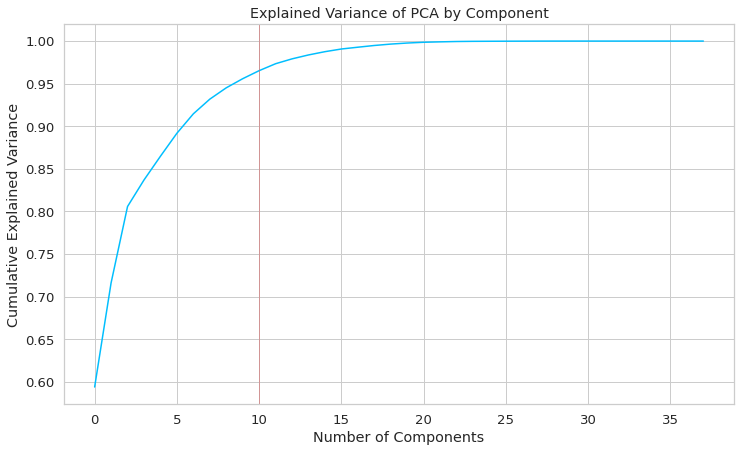

In [220]:
ax = plt.figure(figsize=[12,7]).gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=10, linewidth=1, color='r', alpha=0.5)
plt.title('Explained Variance of PCA by Component')
plt.show()

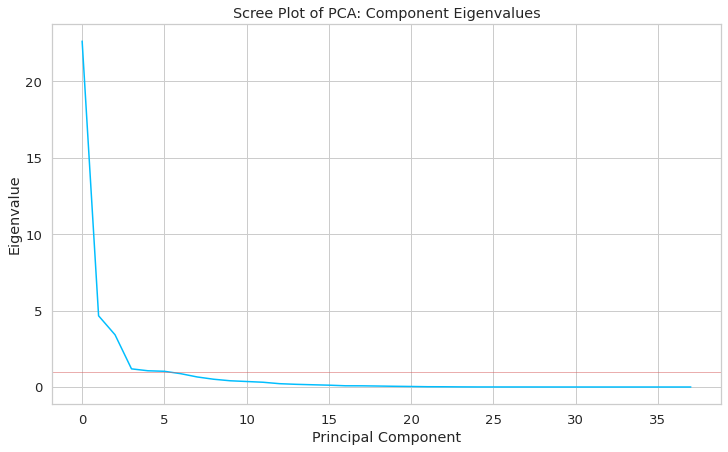

In [221]:
ax = plt.figure(figsize=[12,7]).gca()
ax.plot(pca.explained_variance_)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')
plt.show()

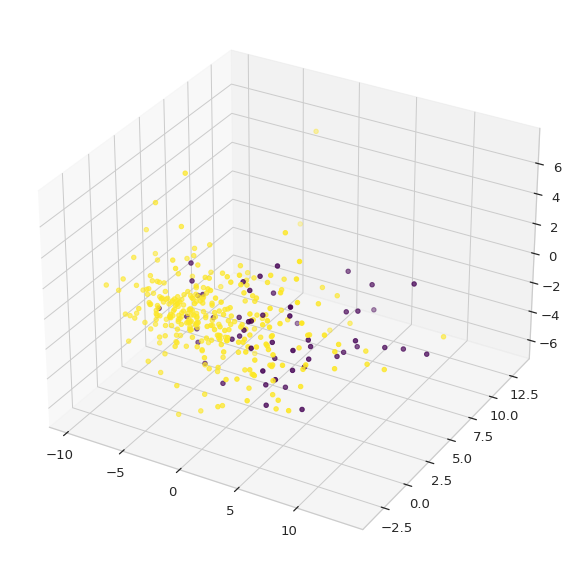

In [222]:
fig = plt.figure(figsize=[10,20])
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y, cmap ='viridis')
plt.show()

In [188]:
y_copy[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [181]:
y_copy = deepcopy(y)

In [182]:
y_copy[y_copy == 0] = 0
y_copy[y_copy == 1] = 0
y_copy[y_copy == 2] = 0
y_copy[y_copy == 3] = 0
y_copy[y_copy == 4] = 0

In [183]:
y_copy

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17

### TSNE

In [223]:
X = deepcopy(X_filt)

caler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_tsne = TSNE(n_components=3, learning_rate='auto',
                init='random').fit_transform(X_normalized)

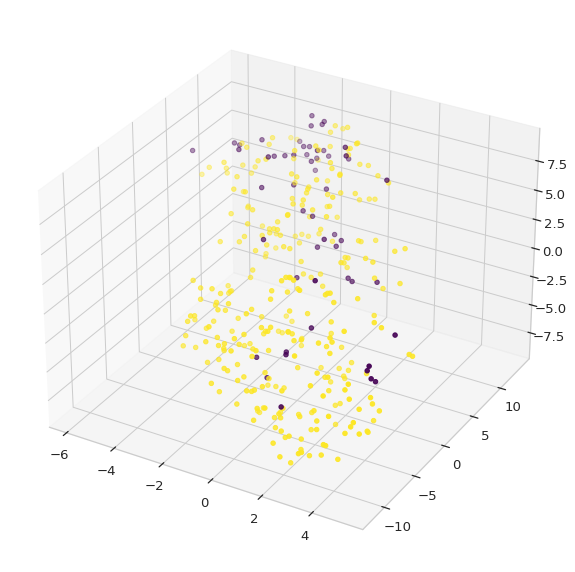

In [224]:
fig = plt.figure(figsize=[10,20])
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = y, cmap ='viridis')
plt.show()